# Sunrise Demo

## Setup

In [1]:
# %load init.py
#@title Import & Utilities
from __future__ import annotations

class AutoImportError(ImportError):
    pass

class auto(object):
    registry: ClassVar[Dict[str, Tuple[str, ...]]] = {}

    @classmethod
    def register(
        cls,
        import_name: str,
        package_name: Optional[str]=None,
        *extra_package_names: List[str],
    ):
        if package_name is None:
            package_name = import_name

        cls.registry[import_name] = (
            package_name,
            *extra_package_names,
        )

    def __getattr__(self, import_name: str):
        import subprocess, importlib, sys

        try:
            return object.__getattribute__(self, import_name)
        except AttributeError:
            pass

        module = None
        try:
            module = importlib.import_module(import_name)
        except ImportError as e:
            package_names = self.registry[import_name]

            process = subprocess.run([
                sys.executable,
                '-m', 'pip',
                'install',
                *package_names,
            ], stdout=subprocess.PIPE, stderr=subprocess.STDOUT, text=True)

            if process.returncode != 0:
                raise AutoImportError(f"Failed to pip install {package_names!r}\n\n{process.stdout.read()}") from e

            try:
                module = importlib.import_module(import_name)
            except ImportError as e:
                raise AutoImportError(f'Import failed a second time, even after a pip install') from e

        assert module is not None
        # print(f'setattr({self!r}, {import_name!r}, {module!r})')
        setattr(self, import_name, module)
        return module

auto.register('np', 'numpy')
auto.register('tqdm')
auto.register('more_itertools', 'more-itertools')
auto.register('torch')
auto.register('peft')
auto.register('guidance')
auto.register('langchain')
auto.register('diffusers')

auto.register('transformers', None, 'transformers', 'accelerate', 'datasets', 'tokenizers', 'evaluate', 'huggingface_hub', 'torch')
auto.register('accelerate', None, 'transformers', 'accelerate', 'datasets', 'tokenizers', 'evaluate', 'huggingface_hub', 'torch')
auto.register('datasets', None, 'transformers', 'accelerate', 'datasets', 'tokenizers', 'evaluate', 'huggingface_hub', 'torch')
auto.register('tokenizers', None, 'transformers', 'accelerate', 'datasets', 'tokenizers', 'evaluate', 'huggingface_hub', 'torch')
auto.register('evaluate', None, 'transformers', 'accelerate', 'datasets', 'tokenizers', 'evaluate', 'huggingface_hub', 'torch')
auto.register('huggingface_hub', None, 'transformers', 'accelerate', 'datasets', 'tokenizers', 'evaluate', 'huggingface_hub', 'torch')

auto = auto()


def doctest(func=None, /, verbose=False, sterile=False):
    def wrapper(func):
        # Thanks https://stackoverflow.com/a/49659927
        import doctest, copy

        # I need this to error out on failure; the default one doesn't.
        def run_docstring_examples(f, globs, verbose=False, name="NoName", compileflags=None, optionflags=0):
            finder = doctest.DocTestFinder(verbose=verbose, recurse=False)
            runner = doctest.DocTestRunner(verbose=verbose, optionflags=optionflags)
            for test in finder.find(func, name, globs=globs):
                runner.run(test, compileflags=compileflags)
            assert runner.failures == 0

        name = func.__name__

        if sterile:
            globs = {}
        else:
            globs = copy.copy(globals())
        globs[name] = func
        run_docstring_examples(func, globs, verbose=verbose, name=name)
        return func

    if func is not None:
        return wrapper(func)
    else:
        return wrapper

try:
    g
except NameError:
    g = {}

try:
    f
except NameError:
    f = {}

def run(func=None, /, name=None, cond=True, splat=False, after=None, scope=None):
    def wrapper(func, /, *, name=name, cond=cond):
        import inspect

        if callable(cond):
            cond = cond()

        if not cond:
            return None

        if name is None:
            name = func.__name__
            
        f[name] = func

        args = []
        for key, parameter in inspect.signature(func).parameters.items():
            if parameter.kind == inspect.Parameter.POSITIONAL_ONLY:
                keys = [key]
                if scope is not None:
                    keys.insert(0, f'{scope}__{key}')
                
                for key in keys:
                    try:
                        value = g[key]
                    except KeyError:
                        continue
                    else:
                        args.append(value)
                        break
                else:
                    raise KeyError(f'None of {keys=!r} found in g')

        ret = func(*args)

        if callable(after):
            after(ret)

        if splat:
            it = ret.items()
        else:
            it = [(name, ret)]

        for name, ret in it:
            if scope is not None:
                name = f'{scope}__{name}'

            g[name] = ret

        return None

    if func is not None:
        return wrapper(func)
    else:
        return wrapper

@auto.IPython.core.magic.register_line_magic
@auto.IPython.core.magic.register_cell_magic
def source(magic_line, magic_cell=None):
    import os, subprocess, shlex

    if magic_cell is None or magic_cell == '':
        before = os.environ.copy()

        process = subprocess.run([
            'bash', '-c', f'source {magic_line}; export',
        ], capture_output=True, text=True)

        after = {}
        for line in process.stdout.split('\n'):
            if line == '': continue
            parts = shlex.split(line)
            assert parts[0] == 'declare', f'{line=!r}'
            assert parts[1] == '-x', f'{line=!r}'
            if '=' not in parts[2]: continue
            name, value = parts[2].split('=', 1)

            if before.get(name, None) == value: continue
            after[name] = value

        magic_cell = f'%%source {magic_line}\n'
        magic_cell += f'os.environ |= {{\n'
        for name, value in after.items():
            magic_cell += f'  {name!r}: '
            if ':' in value:
                magic_cell += f'":".join([\n'
                for value in value.split(':'):
                    magic_cell += f'    {value!r},\n'
                magic_cell += f'  ]),\n'
            else:
                magic_cell += f' {value!r},\n'
        magic_cell += f'}}\n'

        get_ipython().set_next_input(magic_cell, replace=True)

    get_ipython().run_cell(magic_cell)

In [2]:
def __numpy_string_function(arr):
    name = arr.__class__.__name__
    if arr.size < 1024:
        values = auto.numpy.array_repr(auto.numpy.ravel(arr))
    else:
        values = '...'
        
    shape = auto.numpy.shape(arr)
    dtype = arr.dtype
    return f'{name}({values}, {shape=!r}, {dtype=!r})'
auto.numpy.set_string_function(__numpy_string_function, repr=False)
auto.numpy.set_string_function(__numpy_string_function, repr=True)

auto.np.set_printoptions(
    threshold=4,
    edgeitems=0,
)

In [3]:
Degree = auto.typing.NewType('Degree', float)
Radian = auto.typing.NewType('Radian', float)
Meter = auto.typing.NewType('Meter', float)
Kilometer = auto.typing.NewType('Kilometer', float)

In [4]:
def convert_location_to_spatial(
    *,
    lat: Degree,
    lng: Degree,
    alt: Meter,
    math=auto.math,
) -> Tuple[Meter, Meter, Meter]:
    # Thanks https://gis.stackexchange.com/a/4148
    
    #> Note that "Lat/Lon/Alt" is just another name for spherical coordinates, and 
    #> phi/theta/rho are just another name for latitude, longitude, and altitude.
    #> :) (A minor difference: altitude is usually measured from the surface of the 
    #> sphere; rho is measured from the center -- to convert, just add/subtract the 
    #> radius of the sphere.)
    phi: Radian = math.radians(lat)
    theta: Radian = math.radians(lng)
    
    # Thanks https://en.wikipedia.org/wiki/Earth_radius
    #> A globally-average value is usually considered to be 6,371 kilometres (3,959 mi)
    rho: Meter = 6_371_000 + alt
    
    #> x = math.cos(phi) * math.cos(theta) * rho
    x: Meter = math.cos(phi) * math.cos(theta) * rho
    
    #> y = math.cos(phi) * math.sin(theta) * rho
    y: Meter = math.cos(phi) * math.sin(theta) * rho

    #> z = math.sin(phi) * rho # z is 'up'
    z: Meter = math.sin(phi) * rho
    
    #> (Note there's some slightly arbitrary choices here in what each axis means...
    #> you might want 'y' to point at the north pole instead of 'z', for example.)
    
    # I do :)
    y, z = z, y
    
    return x, y, z

In [5]:
@doctest
def convert_tile_coordinates_to_latlng(
    *,
    z: int,
    x: int,
    y: int,
    math=auto.math,
    return_google_maps_url: bool=False,
) -> Tuple[Degree, Degree]:
    r"""

    >>> convert_tile_coordinates_to_latlng(z=15, x=8739, y=12925, return_google_maps_url=True)
    'https://www.google.com/maps/@35.48751102385376,-83.990478515625,15.79z?entry=ttu'

    """
    
    # Thanks https://gis.stackexchange.com/a/133535
    
    #> n = 2 ^ zoom
    n = 2 ** z
    
    #> lon_deg = xtile / n * 360.0 - 180.0
    lon_deg = x / n * 360.0 - 180.0
    
    #> lat_rad = arctan(sinh(π * (1 - 2 * ytile / n)))
    lat_rad = math.atan(math.sinh(math.pi * (1.0 - 2.0 * y / n)))
    
    #> lat_deg = lat_rad * 180.0 / π
    lat_deg = lat_rad * 180.0 / math.pi
    
    if return_google_maps_url:
        return f"""https://www.google.com/maps/@{lat_deg},{lon_deg},15.79z?entry=ttu"""
    
    return lat_deg, lon_deg

In [6]:
@auto.dataclasses.dataclass(eq=True, order=True, frozen=True)
class Coord:
    """Tile image coordinates for mapbox/etc services"""
    z: int
    x: int
    y: int

    @property
    def nw(self) -> Location:
        """North-West lat/lng of current tile"""
        lat, lng = tile_coordinates_to_latlng(
            z=self.z,
            x=self.x,
            y=self.y,
        )
        return Location(lat=lat, lng=lng)

    @property
    def se(self) -> Location:
        """South-East lat/lng of current tile"""
        lat, lng = tile_coordinates_to_latlng(
            z=self.z,
            x=1+self.x,
            y=1+self.y,
        )
        return Location(lat=lat, lng=lng)

@auto.dataclasses.dataclass(eq=True, frozen=True)
class Domain:
    """Lower (inclusive) and upper (inclusive) bounds of latitude/longitude"""
    lo: Coord
    hi: Coord
        
    @property
    def coords(self) -> List[Coord]:
        """All coordinates within lower/upper bounds"""
        coords = []
        for z, x, y in auto.itertools.product(
            range(self.lo.z, 1+self.hi.z),
            range(self.lo.x, 1+self.hi.x),
            range(self.lo.y, 1+self.hi.y),
        ):
            coords.append(Coord(
                z=z,
                x=x,
                y=y,
            ))
        
        return coords

@auto.dataclasses.dataclass(eq=True, order=True, frozen=True)
class Location:
    """Geographical latitude/longitude"""
    lat: Degree
    lng: Degree
    alt: Optional[Meter] = auto.dataclasses.field(default=None)

@auto.dataclasses.dataclass(eq=True, order=True, frozen=True)
class Point:
    x: Kilometer
    y: Kilometer
    z: Kilometer

In [7]:
@auto.dataclasses.dataclass
class TileURL:
    scheme: str
    netloc: str
    prefix: str
    z: int
    x: int
    y: int
    suffix: str
    query: Dict[str, str]
    fragment: str

    @classmethod
    @doctest
    def decode(cls, url: str) -> Self:
        r"""
        
        >>> decode(dict, 'https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/549/806@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg')
        ... # doctest: +NORMALIZE_WHITESPACE
        {'scheme': 'https',
         'netloc': 'atlas-stg.geoplatform.gov',
         'prefix': ['', 'styles', 'v1', 'atlas-user', 'ck58pyquo009v01p99xebegr9', 'tiles', '256'],
         'z': 11,
         'x': 549,
         'y': 806,
         'suffix': '@2x',
         'query': [('access_token',
                    'pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg')],
         'fragment': ''}
        >>> decode(dict, 'https://atlas-stg.geoplatform.gov:443/v4/atlas-user.0000214_pink/11/549/806.png?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg')
        ... # doctest: +NORMALIZE_WHITESPACE
        {'scheme': 'https',
         'netloc': 'atlas-stg.geoplatform.gov:443',
         'prefix': ['', 'v4', 'atlas-user.0000214_pink'],
         'z': 11,
         'x': 549,
         'y': 806,
         'suffix': '.png',
         'query': [('access_token',
                    'pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg')],
         'fragment': ''}
        
        """
        
        scheme, netloc, path, query, fragment = auto.urllib.parse.urlsplit(
            url,
        )
        path = path.split('/')
        *prefix, z, x, suffix = path
        assert (match := auto.re.match(r'^(\d+)(.*)$', suffix)) is not None, \
            f'{suffix = !r}'
        y, suffix = match.groups()
            
        
        z, x, y = map(int, (z, x, y))
        query = auto.urllib.parse.parse_qsl(
            query,
        )

        return cls(
            scheme=scheme,
            netloc=netloc,
            prefix=prefix,
            z=z,
            x=x,
            y=y,
            suffix=suffix,
            query=query,
            fragment=fragment,
        )

    def encode(self) -> str:
        query = auto.urllib.parse.urlencode(
            self.query,
            doseq=True,
        )
        
        z, x, y = map(str, (self.z, self.x, self.y))

        path = '/'.join([
            *self.prefix,
            z,
            x,
            y + self.suffix,
        ])

        return auto.urllib.parse.urlunsplit((
            self.scheme,
            self.netloc,
            path,
            query,
            self.fragment,
        ))
    

In [8]:
@run(cond='cache' not in g)
def cache():
    return {}

@run
def cache(cache, /):
    def load() -> Dict:
        ret = {}
        try:
            with open(path, 'rb') as f:
                ret = auto.pickle.load(f)
                print(f'Read {f.tell():,d} bytes from {path}')
        except Exception as e:
            print('load failed:')
            auto.traceback.print_exception(e)
        
        return ret
    
    def merge(mutable: Dict, constant: Dict):
        try:
            for k, v in constant.items():
                if k in mutable:
                    continue

                mutable[k] = v
        except Exception as e:
            print('merge failed:')
            auto.traceback.print_exception(e)
    
    def dump(d: Dict):
        try:
            with open(path, 'wb') as f:
                auto.pickle.dump(d, f)

                print(f'Wrote {f.tell():,d} bytes to {path}')
        except Exception as e:
            print('dump failed:')
            auto.traceback.print_exception(e)
        
    path = auto.pathlib.Path.cwd() / 'tmp' / 'Sunrise Demo Cache.pickle'
    
    if path.exists():
        merge(cache, load())
    
    dump(cache)
    
    return cache

Read 18,018,813 bytes from /home/thobson2/src/Sunrise-Demo/tmp/Sunrise Demo Cache.pickle
Wrote 18,018,813 bytes to /home/thobson2/src/Sunrise-Demo/tmp/Sunrise Demo Cache.pickle


In [9]:
@run
def fetch(cache, /):
    def fetch(url: str, *, tqdm=None) -> bytes:
        key = url
        if key not in cache:
            if tqdm is not None:
                tqdm.set_description(f'Cache Miss: {url}')

            with auto.requests.get(url) as r:
                r.raise_for_status()
                cache[key] = r.content
            
            auto.time.sleep(1)
        
        else:
            if tqdm is not None:
                tqdm.set_description('Cache Hit: {url}')
        
        return cache[key]

    return fetch

## Background

In [10]:
@run(after=auto.pprint.pp, scope='background')
def domain():
    from bs4 import BeautifulSoup
    
    soup = BeautifulSoup(r'''
        <img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/548/806@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(439px, -19px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/549/806@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(695px, -19px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/548/807@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(439px, 237px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/549/807@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(695px, 237px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/547/806@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(183px, -19px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/550/806@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(951px, -19px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/547/807@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(183px, 237px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/550/807@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(951px, 237px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/546/806@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(-73px, -19px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/551/806@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(1207px, -19px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/546/807@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(-73px, 237px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/551/807@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(1207px, 237px, 0px); opacity: 1;">
        <img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/548/806@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(439px, -19px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/549/806@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(695px, -19px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/548/807@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(439px, 237px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/549/807@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(695px, 237px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/547/806@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(183px, -19px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/550/806@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(951px, -19px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/547/807@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(183px, 237px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/550/807@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(951px, 237px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/546/806@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(-73px, -19px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/551/806@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(1207px, -19px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/546/807@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(-73px, 237px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/551/807@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(1207px, 237px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/548/805@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(439px, -275px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/549/805@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(695px, -275px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/547/805@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(183px, -275px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/550/805@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(951px, -275px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/546/805@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(-73px, -275px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/551/805@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(1207px, -275px, 0px); opacity: 1;">
        <img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/548/806@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(439px, -19px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/549/806@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(695px, -19px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/548/807@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(439px, 237px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/549/807@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(695px, 237px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/547/806@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(183px, -19px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/550/806@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(951px, -19px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/547/807@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(183px, 237px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/550/807@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(951px, 237px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/546/806@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(-73px, -19px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/551/806@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(1207px, -19px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/546/807@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(-73px, 237px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/551/807@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(1207px, 237px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/548/805@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(439px, -275px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/549/805@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(695px, -275px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/547/805@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(183px, -275px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/550/805@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(951px, -275px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/546/805@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(-73px, -275px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/551/805@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(1207px, -275px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/548/808@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(439px, 493px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/549/808@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(695px, 493px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/547/808@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(183px, 493px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/550/808@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(951px, 493px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/546/808@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(-73px, 493px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/551/808@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(1207px, 493px, 0px); opacity: 1;">
    ''', 'html.parser')
    
    urls = []
    for img in soup('img'):
        src = img['src']
        url = TileURL.decode(src)
        urls.append(url)
    
    return Domain(
        lo=Coord(
            z=min(url.z for url in urls),
            x=min(url.x for url in urls),
            y=min(url.y for url in urls),
        ),
        hi=Coord(
            z=max(url.z for url in urls),
            x=max(url.x for url in urls),
            y=max(url.y for url in urls),
        ),
    )

Domain(lo=Coord(z=11, x=546, y=805), hi=Coord(z=11, x=551, y=808))


In [11]:
@auto.dataclasses.dataclass(eq=True, frozen=True)
class Tile:
    coord: Coord
    url: str = auto.dataclasses.field(repr=False)
    image: bytes = auto.dataclasses.field(repr=False)

@run(scope='background', after=lambda x: print(len(x)))
def tiles(domain, fetch, /):
    def make_url(coord: Coord, /, *, url=TileURL.decode(
        r"""https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/549/806@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg"""
    )):
        return auto.dataclasses.replace(
            url,
            z=coord.z,
            x=coord.x,
            y=coord.y,
        )
    
    tiles = []
    for coord in (tqdm := auto.tqdm.tqdm(domain.coords)):
        url = make_url(coord).encode()
        image = fetch(url, tqdm=tqdm)

        tiles.append(Tile(
            coord=coord,
            url=url,
            image=image,
        ))

    return tiles

Cache Hit: {url}: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 24/24 [00:00<00:00, 971.97it/s]

24


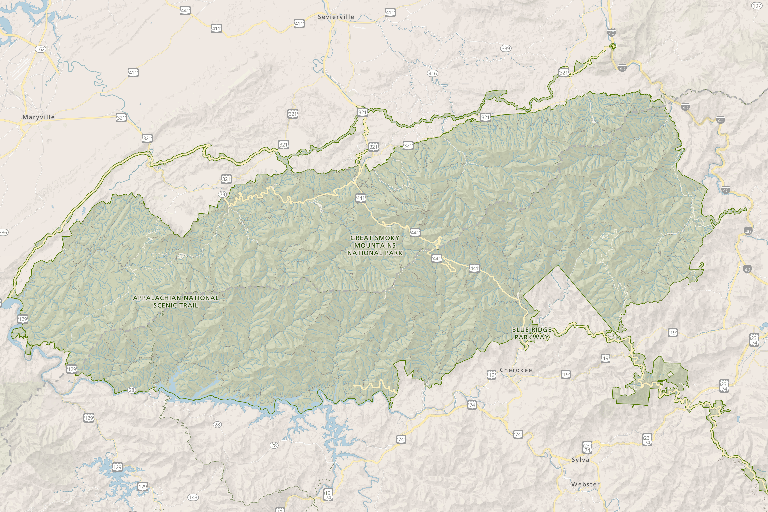

In [12]:
auto.register('PIL', 'Pillow')

@run(scope='background', after=auto.IPython.display.display)
def __stitch_tiles(tiles, /):
    auto.PIL; from PIL import Image
    
    xs = set(tile.coord.x for tile in tiles)
    ys = set(tile.coord.y for tile in tiles)
    
    xs = sorted(xs)
    ys = sorted(ys)
    
    nx = len(xs)
    ny = len(ys)
    
    sz = 128
    
    composite = Image.new('RGB', (nx*sz, ny*sz))
    
    for tile in tiles:
        xi = xs.index(tile.coord.x)
        yi = ys.index(tile.coord.y)
        
        with auto.io.BytesIO(tile.image) as f:
            try:
                image = Image.open(f)
            except auto.PIL.UnidentifiedImageError:
                continue

            image.thumbnail((sz, sz))

        composite.paste(image, (xi*sz, yi*sz))
    
    return composite

## Elevation

In [13]:
@run(scope='elevation')
def domain(background__domain, /):
    return background__domain

@run(scope='elevation')
def tiles(domain, fetch, /):
    def make_url(coord: Coord, /, *, url=TileURL.decode(
        r"""https://api.mapbox.com/v4/mapbox.terrain-rgb/14/3826/6127@2x.pngraw?access_token=pk.eyJ1IjoidGhvYnNvbjIiLCJhIjoiY2oxZmdqbnQzMDBpbjJxczR6dWoyemUxNiJ9.SEBHSdHLP_lZGD43r-_IDQ"""
    )) -> URL:
        return auto.dataclasses.replace(
            url,
            z=coord.z,
            x=coord.x,
            y=coord.y,
        )
    
    tiles = []
    for coord in (tqdm := auto.tqdm.tqdm(domain.coords)):
        url = make_url(coord).encode()
        image = fetch(url, tqdm=tqdm)
        
        tiles.append(Tile(
            coord=coord,
            url=url,
            image=image,
        ))
    
    return tiles

Cache Hit: {url}: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 24/24 [00:00<00:00, 905.05it/s]


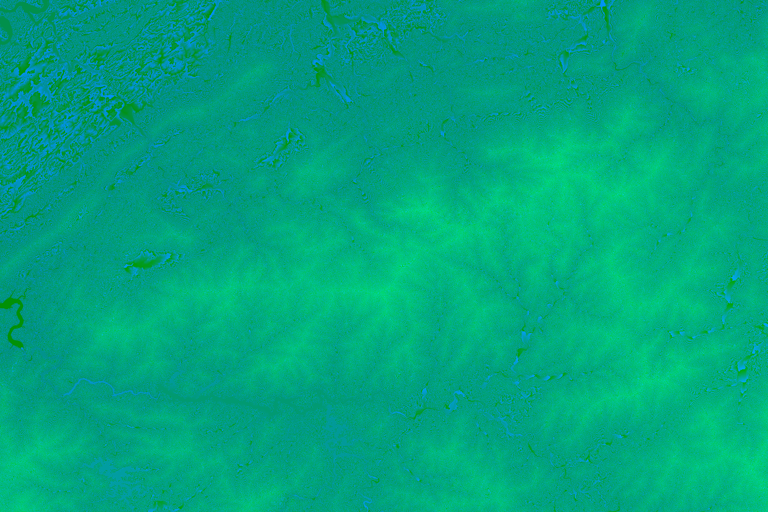

In [14]:
f['__stitch_tiles'](g['elevation__tiles'])

## Observations

In [15]:
@auto.dataclasses.dataclass(eq=True, frozen=True)
class Observation:
    common_name: str
    irma_id: str
    latin_name_ref: str
    latin_name: str

@run
def observations(fetch, /):
    observations = []
    for observation in (
        Observation(**kwargs)
        for kwargs in (
            auto.json.loads(fetch('https://species.atlasofthesmokies.org/atbirecords/lexical_index.json'))
        )['items']
    ):
        observations.append(observation)
    
    return observations

In [16]:
@run(after=print)
def observation(observations, /):
    for observation in observations:
        if observation.common_name not in [
            'Alternate-Leaf Dogwood',
#             'A Spiny Crawler Mayfly',
#             'Acadian Flycatcher',
#             'Agreeable Tiger Moth',
        ]:
            continue
        
        return observation

Observation(common_name='Alternate-Leaf Dogwood', irma_id='0010099', latin_name_ref='Cornus alternifolia', latin_name='Cornus_alternifolia')


In [17]:
@run(scope='observation', after=print)
def domain():
    from bs4 import BeautifulSoup
    
    soup = BeautifulSoup('''
    <img alt="" role="presentation" src="data:image/gif;base64,R0lGODlhAQABAAD/ACwAAAAAAQABAAACADs=" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(183px, -19px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov:443/v4/atlas-user.0000214_pink/11/548/806.png?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(439px, -19px, 0px); opacity: 1;"><img alt="" role="presentation" src="data:image/gif;base64,R0lGODlhAQABAAD/ACwAAAAAAQABAAACADs=" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(183px, -275px, 0px); opacity: 1;"><img alt="" role="presentation" src="data:image/gif;base64,R0lGODlhAQABAAD/ACwAAAAAAQABAAACADs=" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(439px, -275px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov:443/v4/atlas-user.0000214_pink/11/547/807.png?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(183px, 237px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov:443/v4/atlas-user.0000214_pink/11/548/807.png?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(439px, 237px, 0px); opacity: 1;"><img alt="" role="presentation" src="data:image/gif;base64,R0lGODlhAQABAAD/ACwAAAAAAQABAAACADs=" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(-73px, -19px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov:443/v4/atlas-user.0000214_pink/11/549/806.png?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(695px, -19px, 0px); opacity: 1;"><img alt="" role="presentation" src="data:image/gif;base64,R0lGODlhAQABAAD/ACwAAAAAAQABAAACADs=" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(-73px, -275px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov:443/v4/atlas-user.0000214_pink/11/549/805.png?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(695px, -275px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov:443/v4/atlas-user.0000214_pink/11/546/807.png?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(-73px, 237px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov:443/v4/atlas-user.0000214_pink/11/549/807.png?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(695px, 237px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov:443/v4/atlas-user.0000214_pink/11/550/806.png?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(951px, -19px, 0px); opacity: 1;"><img alt="" role="presentation" src="data:image/gif;base64,R0lGODlhAQABAAD/ACwAAAAAAQABAAACADs=" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(951px, -275px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov:443/v4/atlas-user.0000214_pink/11/550/807.png?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(951px, 237px, 0px); opacity: 1;">
    <img alt="" role="presentation" src="data:image/gif;base64,R0lGODlhAQABAAD/ACwAAAAAAQABAAACADs=" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(183px, -19px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov:443/v4/atlas-user.0000214_pink/11/548/806.png?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(439px, -19px, 0px); opacity: 1;"><img alt="" role="presentation" src="data:image/gif;base64,R0lGODlhAQABAAD/ACwAAAAAAQABAAACADs=" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(183px, -275px, 0px); opacity: 1;"><img alt="" role="presentation" src="data:image/gif;base64,R0lGODlhAQABAAD/ACwAAAAAAQABAAACADs=" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(439px, -275px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov:443/v4/atlas-user.0000214_pink/11/547/807.png?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(183px, 237px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov:443/v4/atlas-user.0000214_pink/11/548/807.png?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(439px, 237px, 0px); opacity: 1;"><img alt="" role="presentation" src="data:image/gif;base64,R0lGODlhAQABAAD/ACwAAAAAAQABAAACADs=" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(-73px, -19px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov:443/v4/atlas-user.0000214_pink/11/549/806.png?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(695px, -19px, 0px); opacity: 1;"><img alt="" role="presentation" src="data:image/gif;base64,R0lGODlhAQABAAD/ACwAAAAAAQABAAACADs=" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(-73px, -275px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov:443/v4/atlas-user.0000214_pink/11/549/805.png?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(695px, -275px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov:443/v4/atlas-user.0000214_pink/11/546/807.png?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(-73px, 237px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov:443/v4/atlas-user.0000214_pink/11/549/807.png?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(695px, 237px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov:443/v4/atlas-user.0000214_pink/11/550/806.png?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(951px, -19px, 0px); opacity: 1;"><img alt="" role="presentation" src="data:image/gif;base64,R0lGODlhAQABAAD/ACwAAAAAAQABAAACADs=" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(951px, -275px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov:443/v4/atlas-user.0000214_pink/11/550/807.png?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(951px, 237px, 0px); opacity: 1;"><img alt="" role="presentation" src="data:image/gif;base64,R0lGODlhAQABAAD/ACwAAAAAAQABAAACADs=" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(695px, 493px, 0px); opacity: 1;"><img alt="" role="presentation" src="data:image/gif;base64,R0lGODlhAQABAAD/ACwAAAAAAQABAAACADs=" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(951px, 493px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov:443/v4/atlas-user.0000214_pink/11/551/807.png?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(1207px, 237px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov:443/v4/atlas-user.0000214_pink/11/551/806.png?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(1207px, -19px, 0px); opacity: 1;"><img alt="" role="presentation" src="data:image/gif;base64,R0lGODlhAQABAAD/ACwAAAAAAQABAAACADs=" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(439px, 493px, 0px); opacity: 1;"><img alt="" role="presentation" src="data:image/gif;base64,R0lGODlhAQABAAD/ACwAAAAAAQABAAACADs=" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(1207px, 493px, 0px); opacity: 1;"><img alt="" role="presentation" src="data:image/gif;base64,R0lGODlhAQABAAD/ACwAAAAAAQABAAACADs=" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(183px, 493px, 0px); opacity: 1;">
    <img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov:443/v4/atlas-user.0013547_pink/11/548/806.png?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(439px, -19px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov:443/v4/atlas-user.0013547_pink/11/549/806.png?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(695px, -19px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov:443/v4/atlas-user.0013547_pink/11/548/807.png?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(439px, 237px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov:443/v4/atlas-user.0013547_pink/11/549/807.png?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(695px, 237px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov:443/v4/atlas-user.0013547_pink/11/547/806.png?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(183px, -19px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov:443/v4/atlas-user.0013547_pink/11/550/806.png?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(951px, -19px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov:443/v4/atlas-user.0013547_pink/11/547/807.png?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(183px, 237px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov:443/v4/atlas-user.0013547_pink/11/550/807.png?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(951px, 237px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov:443/v4/atlas-user.0013547_pink/11/546/806.png?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(-73px, -19px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov:443/v4/atlas-user.0013547_pink/11/551/806.png?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(1207px, -19px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov:443/v4/atlas-user.0013547_pink/11/546/807.png?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(-73px, 237px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov:443/v4/atlas-user.0013547_pink/11/551/807.png?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(1207px, 237px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov:443/v4/atlas-user.0013547_pink/11/548/808.png?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(439px, 493px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov:443/v4/atlas-user.0013547_pink/11/549/808.png?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(695px, 493px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov:443/v4/atlas-user.0013547_pink/11/547/808.png?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(183px, 493px, 0px); opacity: 1;"><img alt="" role="presentation" src="data:image/gif;base64,R0lGODlhAQABAAD/ACwAAAAAAQABAAACADs=" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(951px, 493px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov:443/v4/atlas-user.0013547_pink/11/546/808.png?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(-73px, 493px, 0px); opacity: 1;"><img alt="" role="presentation" src="data:image/gif;base64,R0lGODlhAQABAAD/ACwAAAAAAQABAAACADs=" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(1207px, 493px, 0px); opacity: 1;">
    ''', 'html.parser')
    
    urls = []
    for img in soup('img'):
        src = img['src']
        try:
            url = TileURL.decode(src)
        except:
#             print(f'Bad! {src=!r}')
            pass
        else:
            urls.append(url)
    
    return Domain(
        lo=Coord(
            z=min(url.z for url in urls),
            x=min(url.x for url in urls),
            y=min(url.y for url in urls),
        ),
        hi=Coord(
            z=max(url.z for url in urls),
            x=max(url.x for url in urls),
            y=max(url.y for url in urls),
        ),
    )

Domain(lo=Coord(z=11, x=546, y=805), hi=Coord(z=11, x=551, y=808))


In [23]:
@run(scope='observation')
def tiles(domain, observation, fetch, /):
    def make_url(coord: Coord, /, *, url=TileURL.decode(
        r"""https://atlas-stg.geoplatform.gov:443/v4/atlas-user.0000214_pink/11/546/807@2x.png?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg"""
    )) -> TileURL:
        return auto.dataclasses.replace(
            url,
            prefix=['v4', f'atlas-user.{observation.irma_id}_pink'],
            z=coord.z,
            x=coord.x,
            y=coord.y,
        )
    
    tiles = []
    for coord in (tqdm := auto.tqdm.tqdm(domain.coords)):
        url = make_url(coord).encode()
        try:
            image = fetch(url, tqdm=tqdm)
        except auto.requests.HTTPError:
            continue
            
        if image == b'{"message":"Tile does not exist"}':
            continue
        
        tiles.append(Tile(
            coord=coord,
            url=url,
            image=image,
        ))
    
    return tiles

Cache Miss: https://atlas-stg.geoplatform.gov:443/v4/atlas-user.0010099_pink/11/551/808@2x.png?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFm


/home/thobson2/.local/lib/virtualenvs/notebook/lib/python3.10/site-packages/PIL/Image.py:970: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


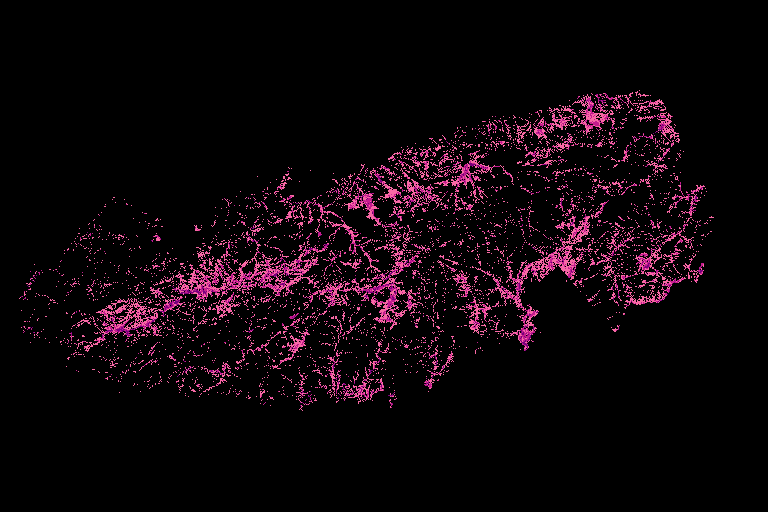

In [24]:
f['__stitch_tiles'](g['observation__tiles'])

## OSPRay

In [25]:
@run(scope='observation', cond=False)
def __estimate_data_sizes(tiles, /):
    from PIL import Image
    
    nx = len(set(tile.coord.x for tile in tiles))
    ny = len(set(tile.coord.y for tile in tiles))
    
    for tile in tiles:
        with auto.io.BytesIO(tile.image) as f:
            image = Image.open(f)
            image.load()

            width = image.width
            height = image.height

            assert width == height, \
                f'non-square {width=} {height=}'

    resolution = width
    x_resolution = nx*resolution
    y_resolution = ny*resolution
    print(f"""For an 2D RGB texture of uint8_t of size { x_resolution :,d}x{ y_resolution :,d}:""")
    texture_bytes = 4 * x_resolution * y_resolution
    print(f"""  the file would be { texture_bytes :,d} bytes""")
    
    print(f"""For a triangle mesh:""")
    n_vertices = (x_resolution) * (y_resolution)
    print(f"""  number of vertices = { n_vertices :,d} ({ 3*4*n_vertices :,d} bytes of vec3f data)""")
    n_edges = x_resolution * y_resolution * 3
    print(f"""  number of edges = { n_edges :,d} ({ 4*4*n_edges :,d} bytes of vec4ui data)""")

In [47]:
@run(scope='__faster_categorization', cond=False)
def res():
    return 512

@run(scope='__faster_categorization', cond=False)
def slow(res, observation__tiles, /):
    # Thanks https://species.atlasofthesmokies.org/style.css
    pinks = auto.numpy.array([
        # Black, obviously.
        # Represents 0-25%
        [0, 0, 0],

        #> #legend-pink-50 { background-color: #f069a3; }
        # Represents 25-50%
        [247, 105, 164],

        #> #legend-pink-75 { background-color: #c31d8e; }
        # Represents 50-75%
        [196, 28, 142],

        #> #legend-pink-100 { background-color: #752879; }
        # Represents 75-100%
        [121, 0, 124],
    ], dtype=auto.numpy.uint8)

    def __category_slow(tile: Tile, /):
        with auto.io.BytesIO(tile.image) as f:
            rgb = auto.PIL.Image.open(f)
            rgb.load()
        
        rgb = rgb.convert('RGB')
        rgb = auto.np.array(rgb)
        rgb = rgb[:res, :res, :]
        
        category = auto.np.zeros(
            shape=(res, res, 1),
            dtype=auto.np.uint8,
        )
        
        for ri, ci in auto.itertools.product(
            range(res),
            range(res),
        ):
            color = rgb[ri, ci, :]
            if ri == 304 and ci == 506:
                print(f'{color.tolist()=!r} {color=!r}')
                
            dists = []
            for pink in pinks:
                if ri == 304 and ci == 506:
                    print(f'{pink.tolist()=!r} {pink=!r}')
#                 dist = auto.numpy.sqrt(auto.numpy.sum((color - pink) ** 2))
                dist = auto.numpy.linalg.norm(auto.numpy.subtract(color, pink, dtype=auto.numpy.float32))
                if ri == 304 and ci == 506:
                    print(f'{dist=!r}')
                dists.append(dist)

            if ri == 304 and ci == 506:
                print(f'{color=!r}')
                print(f'{dists=!r}')
                print(f'{pinks=!r}')

            category[ri, ci, 0] = auto.numpy.argmin(dists)
        
        return category
    
    slow = __category_slow(observation__tiles[0])
    return slow

color.tolist()=[222, 68, 153] color=ndarray(array([222,  68, 153], dtype=uint8), shape=(3,), dtype=dtype('uint8'))
pink.tolist()=[0, 0, 0] pink=ndarray(array([0, 0, 0], dtype=uint8), shape=(3,), dtype=dtype('uint8'))
dist=278.05936
pink.tolist()=[247, 105, 164] pink=ndarray(array([247, 105, 164], dtype=uint8), shape=(3,), dtype=dtype('uint8'))
dist=45.98913
pink.tolist()=[196, 28, 142] pink=ndarray(array([196,  28, 142], dtype=uint8), shape=(3,), dtype=dtype('uint8'))
dist=48.959167
pink.tolist()=[121, 0, 124] pink=ndarray(array([121,   0, 124], dtype=uint8), shape=(3,), dtype=dtype('uint8'))
dist=125.163895
color=ndarray(array([222,  68, 153], dtype=uint8), shape=(3,), dtype=dtype('uint8'))
dists=[278.05936, 45.98913, 48.959167, 125.163895]
pinks=ndarray(array([..., 124], dtype=uint8), shape=(4, 3), dtype=dtype('uint8'))


In [50]:
@run(scope='__faster_categorization', cond=False)
def fast(res, slow, observation__tiles, /):
    ri = 304
    ci = 506
    i = ri * res + ci
    
    # Thanks https://species.atlasofthesmokies.org/style.css
    pinks = auto.numpy.array([
        # Black, obviously.
        # Represents 0-25%
        [0, 0, 0],

        #> #legend-pink-50 { background-color: #f069a3; }
        # Represents 25-50%
        [247, 105, 164],

        #> #legend-pink-75 { background-color: #c31d8e; }
        # Represents 50-75%
        [196, 28, 142],

        #> #legend-pink-100 { background-color: #752879; }
        # Represents 75-100%
        [121, 0, 124],
    ], dtype=auto.numpy.uint8)
        
    def __category_fast(tile: Tile, /):
        with auto.io.BytesIO(tile.image) as f:
            rgb = auto.PIL.Image.open(f)
            rgb.load()
        
        rgb = rgb.convert('RGB')
        rgb = auto.numpy.array(rgb)
        
        rgb = rgb[:res, :res, :]
        
        rgb = rgb.reshape((res*res, 3))
        
        diffs = auto.numpy.subtract(rgb[:, None, :], pinks[None, :, :], dtype=auto.numpy.float32)
        assert diffs.shape == (res*res, len(pinks), 3)
        
        dists = auto.numpy.linalg.norm(diffs, axis=-1)
        assert dists.shape == (res*res, len(pinks))
        
        category = auto.numpy.argmin(dists, axis=-1, keepdims=True)
        assert category.shape == (res*res, 1)
        
        category = category.astype(auto.numpy.uint8)
        category = category.reshape((res, res, 1))
        return category
        
#         print(f'{rgb.shape=!r} {rgb[i, ...]=!r}')
#         x = rgb[:, None, :]
#         print(f'{x.shape=!r} {x[i, ...]=!r}')
        
#         print(f'{pinks.shape=!r} {pinks[0, ...]=!r}')
#         print(f'{pinks.shape=!r} {pinks[2, ...]=!r}')
#         y = pinks[None, :, :]
#         print(f'{y.shape=!r} {y[...]=!r}')
        
#         z = auto.numpy.subtract(x, y, dtype=auto.numpy.float32)
#         print(f'{z.shape=!r} {z[i, ...]=!r}')
#         z = auto.numpy.linalg.norm(z, axis=-1)
#         print(f'{z.shape=!r} {z[i, ...]=!r}')
#         z = auto.numpy.argmin(z, axis=-1, keepdims=True)
#         print(f'{z.shape=!r} {z[i, ...]=!r}')
#         z = z.astype(auto.numpy.uint8)
#         print(f'{z.shape=!r} {z[i, ...]=!r}')
        
#         z = z.reshape((res, res, 1))
#         print(f'{z.shape=!r} {z[0, 0, ...]=!r}')
        
#         x = rgb[:, :, :, None] - pinks[None, None, None, 0, :]
#         print(f'{x.shape=!r} {x[0, 0, ...]=!r}')
#         x = x ** 2
#         print(f'{x.shape=!r} {x[0, 0, ...]=!r}')
#         x = auto.numpy.sum(x, axis=-1)
#         print(f'{x.shape=!r} {x[0, 0, ...]=!r}')
#         x = auto.numpy.argmin(x, axis=-1)
#         print(f'{x.shape=!r} {x[0, 0, ...]=!r}')
#         x = x[:, :, None]
#         print(f'{x.shape=!r} {x[0, 0, ...]=!r}')
        
#         return z
        
    fast = __category_fast(observation__tiles[0])
    
    assert fast.shape == slow.shape, \
        f"""Expected same shape: {fast.shape=!r} {slow.shape=!r}"""
    assert fast.dtype == slow.dtype, \
        f"""Expected same type: {fast.dtype=!r} {slow.dtype=!r}"""
    for ri, ci in auto.itertools.product(range(fast.shape[0]), range(fast.shape[1])):
        assert fast[ri, ci, 0] == slow[ri, ci, 0], \
            f"""Expected same value: {fast[ri, ci, 0]!r} == fast[{ri}, {ci}, 0] == slow[{ri}, {ci}, 0] == {slow[ri, ci, 0]!r}"""
    assert auto.numpy.all(fast == slow), \
        f"""Expected same values"""

In [51]:
%%time

@auto.dataclasses.dataclass(eq=True, frozen=True)
class Terrain:
    domain: Domain
    location: auto.numpy.ndarray[tuple[Any, Any, Literal[3]], auto.numpy.float32]
    category: auto.numpy.ndarray[tuple[Any, Any, Literal[1]], auto.numpy.uint8]
    background: auto.numpy.ndarray[tuple[Any, Any, Literal[3]], auto.numpy.uint8]

@run(after=print)
def terrain(
    background__domain, observation__domain, elevation__domain,
    background__tiles, observation__tiles, elevation__tiles,
    /,
):
    auto.PIL; import PIL.Image
    np = auto.numpy
    
    def tile_altitude(tile: Tile, /) -> np.NDArray[np.float32]:
        with auto.io.BytesIO(tile.image) as f:
            image = auto.PIL.Image.open(f)
            image.load()
        
        image = image.convert('RGB')
        
        rgb = np.array(image)
        assert len(rgb.shape) == 3, \
            f"""Expected dimension 3: {rgb.shape=!r}"""
        assert rgb.shape[0] == rgb.shape[1], \
            f"""Expected square image: {rgb.shape=!r}"""
        assert rgb.shape[0] == res, \
            f"""Expected resolution: {res}; Got resolution: {rgb.shape[0]}"""
        assert rgb.shape[2] == 3, \
            f"""Expected last component to be rgb values: {rgb.shape=!r}"""
        assert rgb.dtype == np.uint8, \
            f"""Expected dtype to be uint8_t: {rgb.dtype=!r}"""
        
        # Thanks https://docs.mapbox.com/data/tilesets/guides/access-elevation-data/#decode-data
        #> elevation = -10000 + (({R} * 256 * 256 + {G} * 256 + {B}) * 0.1)
        
        altitude = np.zeros(
            shape=(rgb.shape[0], rgb.shape[1]),
            dtype=np.float32,
        )
        
        altitude += rgb[:, :, 0] * (1 * 256 * 256)
        altitude += rgb[:, :, 1] * (1 * 256)
        altitude += rgb[:, :, 2] * (1)
        altitude *= 0.1
        altitude -= 10000
        
        return altitude

    def tile_latlng(tile: Tile, /) -> np.ndarray[tuple[Any, Any, 2], np.float32]:
        nonlocal res
        
        # Thanks https://stackoverflow.com/a/57025941
        assert (res != 0) and (res & (res - 1) == 0), \
            f"""Expected resolution to be power-of-two: {res=!r}"""
        
        dz = int(auto.math.log2(res))
        
        latlng = np.zeros(
            shape=(res, res, 2),
            dtype=np.float32,
        )
        
        for yi, xi in auto.itertools.product(
            range(res),
            range(res),
        ):
            z = tile.coord.z + dz
            x = tile.coord.x * res + xi + 0.5
            y = tile.coord.y * res + yi + 0.5
            
            lat, lng = convert_tile_coordinates_to_latlng(
                z=z,
                x=x,
                y=y,
            )
            
            latlng[yi, xi, 0] = lat
            latlng[yi, xi, 1] = lng
        
        return latlng

    def tile_category(tile: Tile, /) -> np.ndarray[tuple[Any, Any, 1], np.uint8]:
        with auto.io.BytesIO(tile.image) as f:
            rgb = auto.PIL.Image.open(f)
            rgb.load()
        
        rgb = rgb.convert('RGB')
        rgb = np.array(rgb)
        
        # Thanks https://species.atlasofthesmokies.org/style.css
        pinks = auto.numpy.array([
            # Black, obviously.
            # Represents 0-25%
            [0, 0, 0],
            
            #> #legend-pink-50 { background-color: #f069a3; }
            # Represents 25-50%
            [247, 105, 164],
            
            #> #legend-pink-75 { background-color: #c31d8e; }
            # Represents 50-75%
            [196, 28, 142],
            
            #> #legend-pink-100 { background-color: #752879; }
            # Represents 75-100%
            [121, 0, 124],
        ], dtype=auto.numpy.uint8)
        
        rgb = rgb.reshape((res*res, 3))
        
        diffs = auto.numpy.subtract(rgb[:, None, :], pinks[None, :, :], dtype=auto.numpy.float32)
        assert diffs.shape == (res*res, len(pinks), 3)
        
        dists = auto.numpy.linalg.norm(diffs, axis=-1)
        assert dists.shape == (res*res, len(pinks))
        
        category = auto.numpy.argmin(dists, axis=-1, keepdims=True)
        assert category.shape == (res*res, 1)
        
        category = category.astype(auto.numpy.uint8)
        category = category.reshape((res, res, 1))
        return category
    
    def tile_background(tile: Tile, /):
        with auto.io.BytesIO(tile.image) as f:
            rgb = auto.PIL.Image.open(f)
            rgb.load()
        
        rgb = rgb.convert('RGB')
        rgb = np.array(rgb)
        
        return rgb

    assert background__domain == observation__domain == elevation__domain, \
        f"""Expected same domain: {observation__domain=!r} {elevation__domain=!r}"""
    domain = observation__domain
    
    zs = sorted(set(tile.coord.z for tiles in [background__tiles, elevation__tiles, observation__tiles] for tile in tiles))
    ys = sorted(set(tile.coord.y for tiles in [background__tiles, elevation__tiles, observation__tiles] for tile in tiles))
    xs = sorted(set(tile.coord.x for tiles in [background__tiles, elevation__tiles, observation__tiles] for tile in tiles))
    
    assert len(zs) == 1, \
        f"""Expected all at same zoom level: {zs=!r}"""
    
    res = 512
    yres = len(ys) * res
    xres = len(xs) * res
    
#     tiles = {
#         (xs.index(tile.coord.x), ys.index(tile.coord.y)): tile
#         for tile in tiles
#     }
    
    observation__tiles = {
        (tile.coord.y, tile.coord.x): tile
        for tile in observation__tiles
    }
    elevation__tiles = {
        (tile.coord.y, tile.coord.x): tile
        for tile in elevation__tiles
    }
    background__tiles = {
        (tile.coord.y, tile.coord.x): tile
        for tile in background__tiles
    }
    
    location = np.zeros(
        shape=(yres, xres, 3),
        dtype=np.float32,
    )
    category = np.zeros(
        shape=(yres, xres, 1),
        dtype=auto.numpy.uint8,
    )
    background = np.zeros(
        shape=(yres, xres, 3),
        dtype=np.uint8,
    )
    for (yi, y), (xi, x) in auto.tqdm.tqdm(auto.itertools.product(
        enumerate(ys),
        enumerate(xs),
    ), total=len(ys)*len(xs)):
        observation = observation__tiles.get((y, x), None)
        elevation = elevation__tiles[y, x]
        background_tile = background__tiles[y, x]
        
        altitude = tile_altitude(elevation)
        latlng = tile_latlng(elevation)
        
        location[
            (yi+0)*res : (yi+1)*res,
            (xi+0)*res : (xi+1)*res,
            0:2,
        ] = latlng
        
        location[
            (yi+0)*res : (yi+1)*res,
            (xi+0)*res : (xi+1)*res,
            2,
        ] = altitude
        
        background[
            (yi+0)*res : (yi+1)*res,
            (xi+0)*res : (xi+1)*res,
            :,
        ] = tile_background(
            background__tiles[y, x],
        )
        
        if observation is not None:
            category[
                (yi+0)*res : (yi+1)*res,
                (xi+0)*res : (xi+1)*res,
                :,
            ] = 1 + tile_category(observation)
    
    return Terrain(
        domain=domain,
        location=location,
        category=category,
        background=background,
    )

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [00:13<00:00,  1.77it/s]

Terrain(domain=Domain(lo=Coord(z=11, x=546, y=805), hi=Coord(z=11, x=551, y=808)), location=ndarray(..., shape=(2048, 3072, 3), dtype=dtype('float32')), category=ndarray(..., shape=(2048, 3072, 1), dtype=dtype('uint8')), background=ndarray(..., shape=(2048, 3072, 3), dtype=dtype('uint8')))
CPU times: user 13.6 s, sys: 27.9 ms, total: 13.6 s
Wall time: 13.6 s


In [52]:
%%time

@run
def __generate_mesh(terrain, /):
    # Thanks https://species.atlasofthesmokies.org/style.css
    pinks = auto.numpy.array([
        # Black, obviously.
        # Represents 0-25%
        [0, 0, 0],

        #> #legend-pink-50 { background-color: #f069a3; }
        # Represents 25-50%
        [247, 105, 164],

        #> #legend-pink-75 { background-color: #c31d8e; }
        # Represents 50-75%
        [196, 28, 142],

        #> #legend-pink-100 { background-color: #752879; }
        # Represents 75-100%
        [121, 0, 124],
    ], dtype=auto.numpy.uint8)
        
    root = auto.pathlib.Path.home() / 'src' / 'Sunrise-Demo' / 'data'
    root.mkdir(parents=True, exist_ok=True)
    
    with auto.contextlib.ExitStack() as stack:
        @auto.contextlib.contextmanager
        def open(path, mode, /):
            fileobj = None
            try:
                fileobj = auto.builtins.open(path, mode)
                yield fileobj
            finally:
                try:
                    print(f'Wrote {fileobj.tell():,d} bytes to {path}')
                except:
                    pass
            
        def emit(name, format, /, *values, cache={}):
            try:
                fileobj = cache[name]
            except KeyError:
                fileobj = cache[name] = stack.enter_context(open(root / name, 'wb'))
            
            fileobj.write(auto.struct.pack(format, *values))
            
        X, Y, Z = convert_location_to_spatial(
            lat=terrain.location[:, :, 0],
            lng=terrain.location[:, :, 1],
            alt=terrain.location[:, :, 2],
            math=auto.numpy,
        )
        
        nr = X.shape[0]
        nc = X.shape[1]
        
        index = auto.numpy.zeros(
            shape=(nr, nc),
            dtype=auto.numpy.uint32,
        )
        
        for i, (ri, ci) in auto.tqdm.tqdm(enumerate(auto.itertools.product(
            range(nr),
            range(nc),
        )), total=nr*nc, unit='vertex'):
            index[ri, ci] = i
            
            x: Meter = X[ri, ci]
            y: Meter = Y[ri, ci]
            z: Meter = Z[ri, ci]
            
            x: Kilometer = x/1000.0
            y: Kilometer = y/1000.0
            z: Kilometer = z/1000.0
            
            emit('OSPGeometry.mesh.vertex.position.vec3f.bin', 'fff',
                 x,
                 y,
                 z,
            )
            
            br, bg, bb = terrain.background[ri, ci, :] / 255.0
            
            category = terrain.category[ri, ci, 0]
            if category <= 1:
                cr, cg, cb, ca = (0.5, 0.5, 0.5, 0.25)
            
            else:
                cr, cg, cb = pinks[category - 1, :] / 255.0
                ca = 0.25
            
            r = br * (1.0 - ca) + cr * ca
            g = bg * (1.0 - ca) + cg * ca
            b = bb * (1.0 - ca) + cb * ca
            a = 1.0
            
            emit('OSPGeometry.mesh.vertex.color.vec4f.bin', 'ffff',
                 r,
                 g,
                 b,
                 a,
            )
            
        # a -1- b
        # |     |
        # 4     2
        # |     |
        # d -3- c
        
        for ri, ci in auto.tqdm.tqdm(auto.itertools.product(
            range(0, nr-1),
            range(0, nc-1),
        ), total=(nr-1)*(nc-1), unit='face'):
            a = index[ri+0, ci+0]
            b = index[ri+0, ci+1]
            c = index[ri+1, ci+1]
            d = index[ri+1, ci+0]
            
            emit('OSPGeometry.mesh.index.vec4ui.bin', 'IIII',
                 a,
                 b,
                 c,
                 d,
            )
            

100%|██████████████████████████████████████████████████████████████████████████████████████████████| 6286337/6286337 [00:13<00:00, 473189.03face/s]

Wrote 100,581,392 bytes to /home/thobson2/src/Sunrise-Demo/data/OSPGeometry.mesh.index.vec4ui.bin
Wrote 100,663,296 bytes to /home/thobson2/src/Sunrise-Demo/data/OSPGeometry.mesh.vertex.color.vec4f.bin
Wrote 75,497,472 bytes to /home/thobson2/src/Sunrise-Demo/data/OSPGeometry.mesh.vertex.position.vec3f.bin
CPU times: user 1min 52s, sys: 25.9 s, total: 2min 18s
Wall time: 1min 39s


In [ ]:
@run
def colors():
    return ['pink', 'blue', 'orange']

In [ ]:
@auto.dataclasses.dataclass(eq=True, frozen=True)
class Earth:
    satellite: auto.numpy.ndarray[tuple[Any, Any, Literal[3]], auto.numpy.uint8]
    location: auto.numpy.ndarray[tuple[Any, Any, Literal[3]], auto.numpy.float32]

@run(after=print)
def earth(fetch, /):
    def Satellite(url: auto.string.Template, /, *, z: int, x: int, y: int, res: int) -> Earth.Satellite:
        url = url.substitute(
            z=str(z),
            x=str(x),
            y=str(y),
        )
        
        with auto.io.BytesIO(fetch(url)) as f:
            image = auto.PIL.Image.open(f)
            image.load()
        
        image = image.convert('RGB')
        rgb = auto.numpy.array(image)
        
        assert res == rgb.shape[0] == rgb.shape[1], \
            f"""Wrong shape: {rgb.shape=!r}"""
    
        return rgb
        
    def Location(url: auto.string.Template, /, *, z: int, x: int, y: int, res: int) -> Earth.Location:
        url = url.substitute(
            z=str(z),
            x=str(x),
            y=str(y),
        )
        
        with auto.io.BytesIO(fetch(url)) as f:
            image = auto.PIL.Image.open(f)
            image.load()
        
        image = image.convert('RGB')
        rgb = auto.numpy.array(image)
        
        assert res == rgb.shape[0] == rgb.shape[1], \
            f"""Wrong shape: {rgb.shape=!r}"""
        
        location = auto.numpy.zeros(
            shape=(res, res, 3),
            dtype=auto.numpy.float32,
        )
        
        # Thanks https://docs.mapbox.com/data/tilesets/guides/access-elevation-data/#decode-data
        #> elevation = -10000 + (({R} * 256 * 256 + {G} * 256 + {B}) * 0.1)
        
        location[:, :, 2] += rgb[:, :, 0] * (1 * 256 * 256)
        location[:, :, 2] += rgb[:, :, 1] * (1 * 256)
        location[:, :, 2] += rgb[:, :, 2] * (1)
        location[:, :, 2] *= 0.1
        location[:, :, 2] -= 10000
        
        # Thanks https://stackoverflow.com/a/57025941
        assert (res != 0) and (res & (res - 1) == 0), \
            f"""Expected resolution to be power-of-two: {res=!r}"""
        
        dz = int(auto.math.log2(res))
        
        for yi, xi in auto.itertools.product(
            range(res),
            range(res),
        ):
            lat, lng = convert_tile_coordinates_to_latlng(
                z=z + dz,
                x=x * res + xi + 0.5,
                y=y * res + yi + 0.5,
            )
            
            location[yi, xi, 0] = lat
            location[yi, xi, 1] = lng
        
        return location
    
    res = 512
    z = 2
    ny = 1 * 2 ** (z - 1)
    nx = 2 * 2 ** (z - 1)
    print(f'{z=} {ny=} {nx=}')
    
    earth = Earth(
        satellite=auto.numpy.zeros(
            shape=(ny*res, nx*res, 3),
            dtype=auto.numpy.uint8,
        ),
        location=auto.numpy.zeros(
            shape=(ny*res, nx*res, 3),
            dtype=auto.numpy.float32,
        ),
    )
    for (yi, y), (xi, x) in auto.itertools.product(
        enumerate(range(0, ny)),
        enumerate(range(0, nx)),
    ):
        earth.satellite[
            (yi+0) * res : (yi+1) * res,
            (xi+0) * res : (xi+1) * res,
            :,
        ] = Satellite(
            auto.string.Template(
                r"""https://api.mapbox.com/v4/mapbox.satellite/${z}/${x}/${y}@2x.pngraw?access_token=pk.eyJ1IjoidGhvYnNvbjIiLCJhIjoiY2oxZmdqbnQzMDBpbjJxczR6dWoyemUxNiJ9.SEBHSdHLP_lZGD43r-_IDQ"""
            ),
            z=2,
            x=x,
            y=y,
            res=res,
        )
        
        earth.location[
            (yi+0) * res : (yi+1) * res,
            (xi+0) * res : (xi+1) * res,
            :,
        ] = Location(
            auto.string.Template(
                r"""https://api.mapbox.com/v4/mapbox.terrain-rgb/${z}/${x}/${y}@2x.pngraw?access_token=pk.eyJ1IjoidGhvYnNvbjIiLCJhIjoiY2oxZmdqbnQzMDBpbjJxczR6dWoyemUxNiJ9.SEBHSdHLP_lZGD43r-_IDQ"""
            ),
            z=2,
            x=x,
            y=y,
            res=res,
        )
    
    return earth
    

In [ ]:
%%time

@run
def __generate_earth_mesh(earth, /):
    root = auto.pathlib.Path.home() / 'src' / 'Sunrise-Demo' / 'data' / 'earth'
    root.mkdir(parents=True, exist_ok=True)
    
    with auto.contextlib.ExitStack() as stack:
        @auto.contextlib.contextmanager
        def open(path, mode, /):
            fileobj = None
            try:
                fileobj = auto.builtins.open(path, mode)
                yield fileobj
            finally:
                try:
                    print(f'Wrote {fileobj.tell():,d} bytes to {path}')
                except:
                    pass
            
        def emit(name, format, /, *values, cache={}):
            try:
                fileobj = cache[name]
            except KeyError:
                fileobj = cache[name] = stack.enter_context(open(root / name, 'wb'))
            
            fileobj.write(auto.struct.pack(format, *values))
            
        lat = earth.location[:, :, 0]
        lng = earth.location[:, :, 1]
        alt = earth.location[:, :, 2] * 0.99
            
        X, Y, Z = convert_location_to_spatial(
            lat=lat,
            lng=lng,
            alt=alt,
            math=auto.numpy,
        )
        
        nr = X.shape[0]
        nc = X.shape[1]
        
        index = auto.numpy.zeros(
            shape=(nr, nc),
            dtype=auto.numpy.uint32,
        )
        
        for i, (ri, ci) in enumerate(auto.itertools.product(range(nr), range(nc))):
            index[ri, ci] = i
            
            x: Meter = X[ri, ci]
            y: Meter = Y[ri, ci]
            z: Meter = Z[ri, ci]
            
            x: Kilometer = x/1000.0
            y: Kilometer = y/1000.0
            z: Kilometer = z/1000.0
            
            emit('OSPGeometry.mesh.vertex.position.vec3f.bin', 'fff',
                 x,
                 y,
                 z,
            )
            
            r, g, b = earth.satellite[ri, ci, :] / 255.0
            
            emit('OSPGeometry.mesh.vertex.color.vec3f.bin', 'fff',
                 r,
                 g,
                 b,
            )
            
        # a -1- b
        # |     |
        # 4     2
        # |     |
        # d -3- c
        
        for ri, ci in auto.itertools.product(
            range(0, nr-1),
            range(0, nc),
        ):
            a = index[(ri+0)%nr, (ci+0)%nc]
            b = index[(ri+0)%nr, (ci+1)%nc]
            c = index[(ri+1)%nr, (ci+1)%nc]
            d = index[(ri+1)%nr, (ci+0)%nc]
            
            emit('OSPGeometry.mesh.index.vec4ui.bin', 'IIII',
                 a,
                 b,
                 c,
                 d,
            )

## Test

In [ ]:
@run
def __camera_coordinates():
    # Thanks https://goo.gl/maps/H1VA3JLmxDk1yet87
    #> 35.463052, -83.303618
    src_lat, src_lng = 35.463052, -83.303618
    src_alt: Meter = 4_000
    
    # Thanks https://goo.gl/maps/PAKfxb4V6Syi5Ey89
    #> 35.608497, -83.433703
    tgt_lat, tgt_lng = 35.608497, -83.433703
    tgt_alt: Meter = 2_000
    
    src_x, src_y, src_z = map(lambda x: x/1000, convert_location_to_spatial(
        lat=src_lat,
        lng=src_lng,
        alt=src_alt,
    ))
    
    tgt_x, tgt_y, tgt_z = map(lambda x: x/1000, convert_location_to_spatial(
        lat=tgt_lat,
        lng=tgt_lng,
        alt=tgt_alt,
    ))
    
    print(f"""Position (Source):
{src_x}, {src_y}, {src_z}
Position (Target):
{tgt_x}, {tgt_y}, {tgt_z}
Direction:
{tgt_x-src_x}, {tgt_y-src_y}, {tgt_z-src_z}""")

In [ ]:
@run
def __camera_coordinates():
    src, dst = {
        "x": -83.70425994533166,
        "y": 35.57451146678854,
    }, {
        "x": -83.65899807857282,
        "y": 35.58174805423522,
    }
    
    src_lat, src_lng = src["y"], src["x"]
    src_alt: Meter = 2_000
    
    tgt_lat, tgt_lng = dst["y"], dst["x"]
    tgt_alt: Meter = 1_500
    
    src_x, src_y, src_z = map(lambda x: x/1000, convert_location_to_spatial(
        lat=src_lat,
        lng=src_lng,
        alt=src_alt,
    ))
    
    tgt_x, tgt_y, tgt_z = map(lambda x: x/1000, convert_location_to_spatial(
        lat=tgt_lat,
        lng=tgt_lng,
        alt=tgt_alt,
    ))
    
    print(f"""Position (Source):
{src_x}, {src_y}, {src_z}
Up:
{src_x}, {src_y}, {src_z}
Position (Target):
{tgt_x}, {tgt_y}, {tgt_z}
Direction:
{tgt_x-src_x}, {tgt_y-src_y}, {tgt_z-src_z}""")

In [37]:
auto.pathlib.Path.cwd()

PosixPath('/home/thobson2/src/Sunrise-Demo')

In [51]:
auto.subprocess.run([
    'bash', '-c', """
        tty=0
        if [ -t 0 ]; then
            tty=1
        fi
        
        echo tty=$tty
    """,
], check=True)

tty=0


CompletedProcess(args=['bash', '-c', '\n        tty=0\n        if [ -t 0 ]; then\n            tty=1\n        fi\n        \n        echo tty=$tty\n    '], returncode=0)

In [53]:
!./go.sh build

exec /home/thobson2/src/Sunrise-Demo/go.sh docker exec /home/thobson2/src/Sunrise-Demo/go.sh cmake build
exec docker exec --tty --interactive --detach-keys=ctrl-q\,ctrl-q --user 1007:1007 --workdir /home/thobson2/src/Sunrise-Demo --env USER --env HOSTNAME sunrise-demo /home/thobson2/src/Sunrise-Demo/go.sh cmake build
exec cmake --build /home/thobson2/src/Sunrise-Demo/build
[100%] Built target main


In [52]:
@run
def __build():
    def ppargs(args: list, /) -> list:
        print(f'$ {auto.shlex.join(map(str, args))}')
        return args
    
    auto.subprocess.run(
        args=ppargs([
            '/home/thobson2/src/Sunrise-Demo/go.sh', 'build',
        ]),
        stdin=auto.subprocess.DEVNULL,
        capture_output=False,
        bufsize=1,
        check=True,
    )

$ /home/thobson2/src/Sunrise-Demo/go.sh build


KeyboardInterrupt: 

In [88]:
@run
def __live_update_image():
    def image(x: float, /) -> bytes:
        image = auto.PIL.Image.effect_mandelbrot((512, 512), (-x, -x, +x, +x), quality=64)
        with auto.io.BytesIO() as f:
            image.save(f, 'JPEG')
            
            return f.getvalue()
    
    @contextgenerator
    def display():
        handle = auto.IPython.display.display(None, display_id=True)
        
        while True:
            image = yield
            handle.display(auto.IPython.display.Javascript(f"""
            (async (output_subarea) => {{
                console.log({{ output_subarea }});
                const output_area = output_subarea.parentNode;
                console.log({{ output_area }});
                const previous = output_subarea.previousSibling;
                const output = output_area.parentNode;
                console.log({{ output }});
                const src = `data:image/jpeg;base64,{image._repr_jpeg_()}`
                let img = output.querySelector('img');
                if (!img) output_subarea.appendChild(img = document.createElement('img'));
                await new Promise((resolve, reject) => {{
                    const img = new Image();
                    img.onload = resolve;
                    img.onerror = reject;
                    img.src = src;
                }});
                img.src = src;
            }})(...element);
            """))
            
        
    
    one = image(2.0)
    two = image(1.9)
#     print(auto.IPython.display.Image(one)._repr_jpeg_())
    
    with display() as display:
        display.send(auto.IPython.display.Image(one))
        auto.time.sleep(5)
        display.send(auto.IPython.display.Image(two))
#     print(handle.display_id)
    
    
#     handle.update(auto.IPython.display.Image(one))
    
#     auto.time.sleep(5)
    
#     handle.update(auto.IPython.display.Image(two))

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

$ ./go.sh main


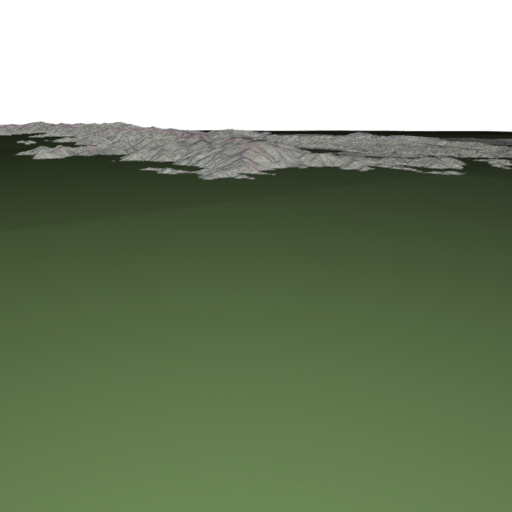

KeyboardInterrupt: 

In [77]:
@auto.dataclasses.dataclass(eq=True, frozen=True)
class Camera:
    position: tuple[float, float, float]
    up: tuple[float, float, float]
    direction: tuple[float, float, float]
        
    def __post_init__(self):
        def unit(v: auto.numpy.typing.ArrayLike):
            v = auto.numpy.asarray(v)
            v = v / auto.numpy.linalg.norm(v)
            return v
        
        unit_up = unit(self.up)
        unit_direction = unit(self.direction)
        assert (dot := auto.numpy.dot(unit_up, unit_direction) < 0.99), \
            f"""Camera up and direction are too similar: {dot=!r}"""

def contextgenerator(func):
    @auto.contextlib.contextmanager
    @auto.functools.wraps(func)
    def wrapper(*args, **kwargs):
        generator = None
        try:
            generator = func(*args, **kwargs)
            next(generator)

            yield generator
        
        finally:
            if generator is not None:
                generator.close()
        
    return wrapper
        
@run
def __render():
    def ppargs(args: list, /) -> list:
        print(f'$ {auto.shlex.join(map(str, args))}')
        return args
    
#     auto.subprocess.run(
#         args=ppargs([
#             './go.sh', 'build',
#         ]),
#         stdin=auto.subprocess.DEVNULL,
#         check=True,
#     )

    @contextgenerator
    def renderer():
        with auto.subprocess.Popen(
            args=ppargs([
                './go.sh', 'main',
            ]),
            stdin=auto.subprocess.PIPE,
            stdout=auto.subprocess.PIPE,
            stderr=auto.subprocess.DEVNULL,
        ) as process:
            def write(s: str, /):
    #             print(f'write({s!r})')
                process.stdin.write(s.encode('utf-8'))
                process.stdin.write(b'\n')
                process.stdin.flush()

            def read() -> bytes:
                def read(format, /) -> tuple[Any]:
                    size = auto.struct.calcsize(format)
                    data = process.stdout.read(size)
                    assert len(data) == size, \
                        f"""Didn't read the entire buffer: {len(data)=!r} {size=!r}"""
                    return auto.struct.unpack(format, data)

                count ,= read('N')
    #             print(f'Reading {count} bytes')
                data ,= read(f'{count}s')
                return data

            image = None
            while True:
                camera = yield image
                write('camera')
                write(' '.join(map(str, camera.position)))
                write(' '.join(map(str, camera.up)))
                write(' '.join(map(str, camera.direction)))
                write(' '.join(map(str, (
                    # imageStart
                    0, 0
                ))))
                write(' '.join(map(str, (
                    # imageEnd
                    1, 1
                ))))

                write('render')

                image = read()
    
    def cameras() -> list[Camera]:
        with open(auto.pathlib.Path.cwd() / 'data' / 'Appalachian_Trail.json', 'r') as f:
            trail = auto.json.load(f)
        
#         trail = trail[::8]
        
        cameras = []
        for window in auto.more_itertools.sliding_window(trail, 3 * (k := 4)):
            srcs = window[:k]
            tgts = window[-k:]
            assert len(srcs) == k
            assert len(tgts) == k
            
            src_lat = auto.statistics.fmean(src["lat"] for src in srcs)
            src_lng = auto.statistics.fmean(src["lng"] for src in srcs)
            src_alt: Meter = 2_000 # * auto.random.uniform(0.9, 1.1)

            tgt_lat = auto.statistics.fmean(tgt["lat"] for tgt in tgts)
            tgt_lng = auto.statistics.fmean(tgt["lng"] for tgt in tgts)
            tgt_alt: Meter = 1_500 # * auto.random.uniform(0.9, 1.1)

            src_x, src_y, src_z = map(lambda x: x/1000, convert_location_to_spatial(
                lat=src_lat,
                lng=src_lng,
                alt=src_alt,
            ))

            tgt_x, tgt_y, tgt_z = map(lambda x: x/1000, convert_location_to_spatial(
                lat=tgt_lat,
                lng=tgt_lng,
                alt=tgt_alt,
            ))
            
            cameras.append(Camera(
                position=(
                    src_x,
                    src_y,
                    src_z,
                ),
                up=(
                    src_x,
                    src_y,
                    src_z,
                ),
                direction=(
                    tgt_x - src_x,
                    tgt_y - src_y,
                    tgt_z - src_z,
                ),
            ))
        
        return cameras
    
    @contextgenerator
    def display():
        handle = auto.IPython.display.display(None, display_id=True)
        
        while True:
            obj = yield
            handle.update(obj)
    
    @contextgenerator
    def ffmpeg():
        # Thanks https://stackoverflow.com/a/43871666
        process = None
        
        try:
            process = auto.subprocess.Popen(
                args=ppargs([
                    'ffmpeg',
                    '-f', 'image2pipe',
                    '-vcodec', 'png',
                    '-r', '30',  # FPS
                    '-i', '-',
                    '-vcodec', 'libx264',
                    '-qscale', '0',
                    '-y',  # overwrite
                    auto.pathlib.Path.cwd() / 'data' / 'video.mp4',
                ]),
                stdin=auto.subprocess.PIPE,
                stdout=auto.subprocess.DEVNULL,
                stderr=auto.subprocess.DEVNULL,
            )
            
            while True:
                image = yield

                process.stdin.write(image)
                process.stdin.flush()
        
        finally:
            if process is not None:
                try:
                    process.stdin.close()
                    process.wait(timeout=10)
                    
                except:
                    process.kill()
            
    cameras = cameras()
    with auto.contextlib.ExitStack() as stack:
        renderer = stack.enter_context(renderer())
        display = stack.enter_context(display())
#         ffmpeg = stack.enter_context(ffmpeg())
        
        for i, camera in enumerate(cameras):
            image = renderer.send(camera)

            display.send(auto.IPython.display.Image(image, width=512, height=512))
#             display.send(f'{i}')
#             ffmpeg.send(image)

In [ ]:
!test -f ./src/main.cpp && rm -f ./build/main && ./go.sh build
!test -f ./build/main && rm -f ./out.png && ./go.sh main
auto.pathlib.Path('out.png').exists() and auto.IPython.display.Image(
    filename='./out.png',
    embed=True,
)